In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import pickle
from scipy import stats
from scipy.spatial.distance import euclidean
import pylab

In [2]:
with open('low_diff_log.pickle','rb') as f:
    df = pickle.load(f)

In [3]:
# limitation: 
# unsupervised, no ground truth, only face validity
# vaguely defined columns
# we assume their ability are around the same level in some cases

In [4]:
#assume context: low ability, difficult problem
#assume three rules
# analyze on student-step level

In [3]:
df.head()

,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,consecutiveErrorsInRow,hint,...,frIsHelpRequest,totalFrPercentPastWrong,frPast5WrongCount,frPast8WrongCount,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING
2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,0,0,...,1,0.0,0,0,0.009561,0.156027,0.916790,0.0,0.468252,0.002815
2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,0,0,...,1,0.0,0,0,0.009561,0.156027,0.926868,0.0,0.468252,0.001483
2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,0,0,...,1,0.0,0,0,0.009561,0.156027,0.937398,0.0,0.468252,0.001483
2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,0,0,...,1,0.0,0,0,0.009561,0.156027,0.810068,0.0,0.149121,0.001483
2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,0,0,...,0,0.0,0,0,0.009561,0.156027,0.730042,0.0,0.149121,0.006837


In [6]:
# basic stats

In [4]:
num_samples = len(df.ITEST_id.unique())
num_samples

668

In [5]:
num_problems = len(df.problemId.unique())
num_problems # number of difficult problems

1410

In [9]:
df_correct_only = df.loc[df.correct==1]

In [10]:
# Distribution of attemptCounts of each problem
df.groupby(['problemId'])['attemptCount'].describe()
x = df.loc[:,['problemId','ITEST_id']].drop_duplicates().reset_index().groupby('problemId').count().describe()
print(x)
# 1403 rows, which means there are 7 of these difficult questions has never been correctly answered

             index     ITEST_id
count  1410.000000  1410.000000
mean     52.068794    52.068794
std      47.618012    47.618012
min       1.000000     1.000000
25%      25.000000    25.000000
50%      37.500000    37.500000
75%      57.000000    57.000000
max     263.000000   263.000000


In [28]:
df['attemptCount'].describe()

count    154515.000000
mean          1.998945
std           1.530975
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          38.000000
Name: attemptCount, dtype: float64

In [11]:
# Distribution of frPast5WrongCount of each student-step
df['frPast5WrongCount'].describe()

count    154515.000000
mean          0.692269
std           0.854414
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: frPast5WrongCount, dtype: float64

In [12]:
df['consecutiveErrorsInRow'].describe() # not quite predictable

count    154515.000000
mean          0.131431
std           0.671021
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: consecutiveErrorsInRow, dtype: float64

In [13]:
# number of hints requested for this problem so far at this step
df['hintCount'].describe() 

count    154515.000000
mean          0.736860
std           1.152348
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          25.000000
Name: hintCount, dtype: float64

In [14]:
# rules:
# 0. start by 0
# 1. when they have more than normal (over 75% quantile) attempt counts over this question by this step, lift by 1 state
# 2. when they have made more than 2 wrong responses in the last 5 first responses, they still attempt, lift by 1 state
# ~(not used) 3. when they skip a problem in less than normal attempt counts (less than 50% quantile), they are less resilient, drop by 2 states
# 4. when they ask for hint in less than normal attempt counts (less than 50% quantile), they are less resilient, drop by 1 state

In [15]:
problem_dist = df_correct_only.groupby(['problemId'])['attemptCount'].describe()
#problem_dist
# define such rule: at 75% quantile of attempts compared to other students in this problem
resilient_rule_attempt_thresholds = {pid:problem_dist.loc[pid]['75%'] for pid in problem_dist.index}
resilient_rule_attempt_thresholds2 = {pid:problem_dist.loc[pid]['50%'] for pid in problem_dist.index}
#problem_dist.loc[3]['50%']

In [16]:
df = df.reset_index()

In [24]:
df['res_level'] = [0]*len(df)
df['skip'] = [0]*len(df)
for i,row in df.iterrows():
    res_level = df.loc[i,'res_level']
    try:
        if i<len(df)-1:
            if df.loc[i,'correct']==0 and i<len(df) and df.loc[i+1,'problemId']!=df.loc[i,'problemId'] and df.loc[i,'ITEST_id']==df.loc[i+1,'ITEST_id']:
                #res_level -=1
                df.at[i,'skip']=1
        if row.attemptCount >= resilient_rule_attempt_thresholds[row.problemId]:
            res_level +=1 
        if row.frPast5WrongCount >= 2:
            res_level+=1
            if row.frPast5WrongCount > 3:
                res_level+=1
        if row.hint==1:
            res_level -=1
        df.at[i,'res_level'] = res_level
    except KeyError:
        print(i,'never corrected answered by these students')

34585 never corrected answered by these students
37323 never corrected answered by these students
100554 never corrected answered by these students
100628 never corrected answered by these students
100712 never corrected answered by these students
100721 never corrected answered by these students
102262 never corrected answered by these students
102278 never corrected answered by these students
108880 never corrected answered by these students
112532 never corrected answered by these students
116181 never corrected answered by these students
118880 never corrected answered by these students
118903 never corrected answered by these students
118909 never corrected answered by these students
119049 never corrected answered by these students
119657 never corrected answered by these students
120526 never corrected answered by these students
121316 never corrected answered by these students
121326 never corrected answered by these students
121343 never corrected answered by these students
12

In [25]:
df.head()

,level_0,index,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,...,frPast5WrongCount,frPast8WrongCount,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,res_level,skip
0,0,2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,...,0,0,0.009561,0.156027,0.916790,0.0,0.468252,0.002815,0,0
1,1,2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,...,0,0,0.009561,0.156027,0.926868,0.0,0.468252,0.001483,0,0
2,2,2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,...,0,0,0.009561,0.156027,0.937398,0.0,0.468252,0.001483,0,0
3,3,2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,...,0,0,0.009561,0.156027,0.810068,0.0,0.149121,0.001483,0,0
4,4,2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,...,0,0,0.009561,0.156027,0.730042,0.0,0.149121,0.006837,0,0


In [26]:
df.res_level.value_counts()

 0    66388
 1    52960
-1    27592
 2     7022
 3      553
Name: res_level, dtype: int64

In [19]:
df = df.reset_index()

In [34]:
df_sample = df.loc[df.ITEST_id==418].rename(columns={"index": "old_index"})
df_sample.reset_index(drop=True,inplace=True)
df_sample = df_sample.reset_index()

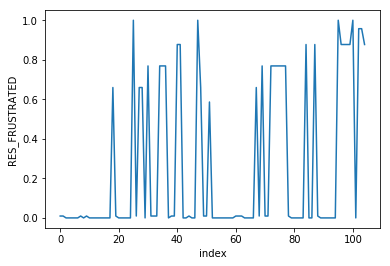

In [35]:
sns.lineplot(x='index',y='RES_FRUSTRATED',data=df_sample)

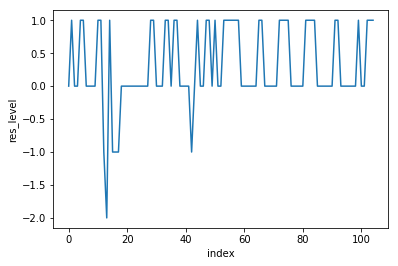

In [36]:
sns.lineplot(x='index',y='res_level',data=df_sample)

In [25]:
sids = df.ITEST_id.unique()
lengths = []
for sid in sids:
    lengths.append(len(df.loc[df.ITEST_id==sid]))
sl = {sids[i]:lengths[i] for i in range(len(sids))}

In [26]:
def agreement_measure(x,y):
    x = np.interp(x, (x.min(), x.max()), (-1, +1))
    #y = np.interp(y, (y.min(), y.max()), (-1, +1)) # y is already a rescaled value
    return euclidean(x,y)/len(x)

In [30]:
avg_agree = []
for sid in sids:
    df_sample = df.loc[df.ITEST_id==sid].rename(columns={"index": "old_index"})
    df_sample.reset_index(drop=True,inplace=True)
    df_sample = df_sample.reset_index()
    agree = agreement_measure(df_sample.res_level.values,df_sample.RES_FRUSTRATED.values)
    #print(sid, agree)
    avg_agree.append(agree)
print(np.sum(avg_agree)/len(sids))

0.058806699007146336


In [27]:
with open('rule_res_model_new.pickle','wb') as f:
    pickle.dump(df,f)

In [23]:
df.head()

,level_0,index,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,...,frPast5WrongCount,frPast8WrongCount,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,res_level,skip
0,0,2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,...,0,0,0.009561,0.156027,0.916790,0.0,0.468252,0.002815,0,0
1,1,2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,...,0,0,0.009561,0.156027,0.926868,0.0,0.468252,0.001483,0,0
2,2,2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,...,0,0,0.009561,0.156027,0.937398,0.0,0.468252,0.001483,0,0
3,3,2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,...,0,0,0.009561,0.156027,0.810068,0.0,0.149121,0.001483,0,0
4,4,2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,...,0,0,0.009561,0.156027,0.730042,0.0,0.149121,0.006837,0,0
